In [16]:
# ! pip install imbalanced-learn
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 
# ! pip install pickle-mixin
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 

In [17]:
import math
import json
import pickle
import numpy as np
import pandas as pd
import coremltools as ct
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

In [18]:
STAGE = {
    'In Bed': 0,
    'Awake': 1,
    'Asleep': 2,
    'REM': 3,
    'Core': 4,
    'Deep': 5,
    'Unknown': 6
}

In [19]:
def load_json(path: str) -> dict:
    with open(path, 'r') as file:
        return json.load(file)

def parse_time(time: str) -> datetime:
    return datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

def to_min(cur_time: datetime, start_time: datetime) -> int:
    return int((cur_time - start_time).total_seconds()//60)

def process_sleep_data(sleep_data: dict) -> dict:
    stages_by_day = defaultdict(dict)

    for data in sleep_data:
        if data['stage'] in ['Awake', 'REM', 'Core', 'Deep']:
            start_time = parse_time(data['start_time'])
            end_time = parse_time(data['end_time'])
            day = end_time.strftime('%Y-%m-%d')

            if not day in stages_by_day:
                stages_by_day[day]['stages'] = list()
                
            stages_by_day[day]['stages'].append({
                'start_time': start_time,
                'end_time': end_time,
                'stage': STAGE[data['stage']]
            })

    for date, data in stages_by_day.items():
        stages_by_day[date]['stages'] = sorted(data['stages'], key=lambda x: x['start_time'])
        stages_by_day[date]['start_time'] = stages_by_day[date]['stages'][0]['start_time']
        stages_by_day[date]['end_time'] = stages_by_day[date]['stages'][-1]['end_time']
        stages_by_day[date]['day_of_week'] = stages_by_day[date]['start_time'].weekday()

    return stages_by_day

def process_heart_rate_data(heart_rate_data: dict, stage_data: dict)  -> dict:
    for data in heart_rate_data:
        start_time = parse_time(data['startDate'])
        end_time = parse_time(data['endDate'])
        day = end_time.strftime('%Y-%m-%d')
        
        if day in stage_data and (stage_data[day]['start_time'] <= start_time and end_time <= stage_data[day]['end_time']):
            if 'heart_rate_intervals' not in stage_data[day]:
                stage_data[day]['heart_rate_intervals'] = []
            stage_data[day]['heart_rate_intervals'].append({
                'start_time': start_time,
                'end_time': end_time,
                'bpm': data['bpm']
            })

    for data in stage_data.values():
        if 'heart_rate_intervals' not in data:
            data['heart_rate_intervals'] = []
            
        data['heart_rate_intervals'] = sorted(data['heart_rate_intervals'], key=lambda x: x['start_time'])
    
    return stage_data

def post_process(stage_data: dict) -> pd.DataFrame:
    def find_closest_heart_rate(heart_rate_intervals, timestamp):
        closest_hr = None
        min_difference = float('inf')

        for hr in heart_rate_intervals:
            start, end, heart_rate = hr['start_time'], hr['end_time'], hr['bpm']
            
            if start <= timestamp <= end:
                return heart_rate
            
            difference = min(abs(start - timestamp), abs(end - timestamp))
            if difference.seconds < min_difference:
                min_difference = difference.seconds
                closest_hr = heart_rate

        return closest_hr

    ml_data = list()
    for date, data in stage_data.items():
       
        for interval,item in enumerate(data['stages']):  # sorted ascendingly
            
            heart_rate_intervals = [d for d in data['heart_rate_intervals'] if (item['start_time'] <= d['start_time'] and d['end_time'] <= item['end_time'])]
            if len(heart_rate_intervals) == 0:
                continue
                
            timeline = []
            current_time = item['start_time']
            while current_time < item['end_time']:
                heart_rate = find_closest_heart_rate(heart_rate_intervals, current_time)
                timeline.append(heart_rate)
                current_time += timedelta(minutes=1)
            
            stime = item['start_time'].time()
            stime_in_min = stime.hour*60 + stime.minute
            etime = item['end_time'].time()
            etime_in_min = etime.hour*60 + etime.minute
            
            desired_size = 159
            hri = timeline + [0] * (desired_size - len(timeline))
            
            if any(v != 0 for v in hri):
                ml_data.append((
                    stime_in_min,
                    etime_in_min,
                    interval,
                    item['stage'],
                    hri
                ))
    return pd.DataFrame(ml_data, columns=['start_time', 'end_time', 'time_step', 'stage', 'heart_rate_intervals'])

In [20]:
sleep_data = load_json('./sleepData.json')['sleep_data']
stage_data = process_sleep_data(sleep_data)

In [21]:
heart_rate_data = load_json('./filteredHeartRate.json')
total_data = process_heart_rate_data(heart_rate_data, stage_data)

In [22]:
ml_data = post_process(total_data)

In [23]:
print(ml_data.head())
ml_data.info()

   start_time  end_time  time_step  stage  \
0         113       127          0      4   
1         127       145          1      5   
2         145       157          2      4   
3         157       167          3      5   
4         167       172          4      4   

                                heart_rate_intervals  
0  [97, 97, 97, 97, 97, 93, 93, 107.0000000000000...  
1  [141, 145, 152, 156, 157, 155, 156, 159, 161, ...  
2  [164, 163, 165, 166, 167, 168, 169.00000000000...  
3  [120, 118, 114, 153, 165, 165, 166, 158, 132, ...  
4  [115, 116, 151, 159, 161, 0, 0, 0, 0, 0, 0, 0,...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   start_time            6277 non-null   int64 
 1   end_time              6277 non-null   int64 
 2   time_step             6277 non-null   int64 
 3   stage                 6277 non-null   

In [24]:
# len(max(ml_data['heart_rate_intervals'].values, key=lambda x: len(x)))
ml_data['interval_size'] = ml_data['end_time'] - ml_data['start_time']
# ml_data['interval_size'].max()
# ml_data.iloc[:100]
# type(ml_data.iloc[0]['heart_rate_intervals'][0])

# print(any(ml_data[ml_data.isnull().any(axis=1)]))
# len(ml_data[ml_data.isnull().any(axis=1)])

# for i in range(1):
#     print(ml_data.iloc[i]['interval_size'], len(ml_data.iloc[i]['heart_rate_intervals']), ml_data.iloc[i]['heart_rate_intervals'])

ml_data.iloc[0]

start_time                                                            113
end_time                                                              127
time_step                                                               0
stage                                                                   4
heart_rate_intervals    [97, 97, 97, 97, 97, 93, 93, 107.0000000000000...
interval_size                                                          14
Name: 0, dtype: object

In [25]:
# X = ml_data[['start_time', 'end_time', 'time_step', 'stage']].values.astype('float32')
# Y = np.vstack(ml_data['heart_rate_intervals'].values).astype('float32')

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # reshape X data into 3-dim for LSTM
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print(X.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(64, return_sequences=False, input_shape=(X.shape[1], 1)),
#     tf.keras.layers.Dense(159)
# ])

# # model = tf.keras.Sequential([
# #     tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
# #     tf.keras.layers.BatchNormalization(),
# #     tf.keras.layers.Dropout(0.3),
# #     tf.keras.layers.LSTM(128, return_sequences=False),
# #     tf.keras.layers.BatchNormalization(),
# #     tf.keras.layers.Dropout(0.3),
# #     tf.keras.layers.Dense(256, activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
# #     tf.keras.layers.Dropout(0.3),
# #     tf.keras.layers.Dense(159)  # Output layer with 1620 neurons for regression
# # ])


# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_split=0.2)


# loss = model.evaluate(X_test, Y_test)
# print("Test Loss:", loss)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
import numpy as np

X = ml_data[['start_time', 'end_time', 'time_step', 'stage']].values.astype('float32')
Y = np.vstack(ml_data['heart_rate_intervals'].values).astype('float32')

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Model definition
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(159)  
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7)

# Model training with early stopping
history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
32/32 [==============================] - 6s 60ms/step - loss: 624.3645 - val_loss: 628.5267
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 608.9774 - val_loss: 626.3943
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 587.5804 - val_loss: 622.7990
Epoch 4/100
32/32 [==============================] - 1s 42ms/step - loss: 556.9183 - val_loss: 572.0027
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 503.2142 - val_loss: 469.1083
Epoch 6/100
32/32 [==============================] - 1s 38ms/step - loss: 435.3264 - val_loss: 463.4208
Epoch 7/100
32/32 [==============================] - 1s 37ms/step - loss: 373.6594 - val_loss: 305.0136
Epoch 8/100
32/32 [==============================] - 1s 37ms/step - loss: 314.6443 - val_loss: 268.4553
Epoch 9/100
32/32 [==============================] - 1s 35ms/step - loss: 261.0612 - val_loss: 369.9037
Epoch 10/100
32/32 [==============================] - 1s 33ms/st

Epoch 80/100
32/32 [==============================] - 1s 34ms/step - loss: 95.4376 - val_loss: 81.2963
Epoch 81/100
32/32 [==============================] - 1s 36ms/step - loss: 95.2485 - val_loss: 81.2702
Epoch 82/100
32/32 [==============================] - 1s 35ms/step - loss: 97.8762 - val_loss: 81.1624
Epoch 83/100
32/32 [==============================] - 1s 35ms/step - loss: 95.7382 - val_loss: 80.6771
Epoch 84/100
32/32 [==============================] - 1s 35ms/step - loss: 94.8477 - val_loss: 80.7924
Epoch 85/100
32/32 [==============================] - 1s 36ms/step - loss: 95.7799 - val_loss: 80.8441
Epoch 86/100
32/32 [==============================] - 1s 35ms/step - loss: 96.7918 - val_loss: 80.7461
Epoch 87/100
32/32 [==============================] - 1s 34ms/step - loss: 93.7422 - val_loss: 80.7221
Epoch 88/100
32/32 [==============================] - 1s 33ms/step - loss: 95.4299 - val_loss: 80.7169
Epoch 89/100
32/32 [==============================] - 1s 34ms/step - loss

In [27]:
loss = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)

40/40 [==============================] - 0s 6ms/step - loss: 85.0489
Test Loss: 85.04889678955078


In [28]:
print(X_test.shape)
print(model.predict(X_test).shape)

(1256, 4, 1)
(1256, 159)


1900-01-01 10:20:00 1900-01-01 11:01:00


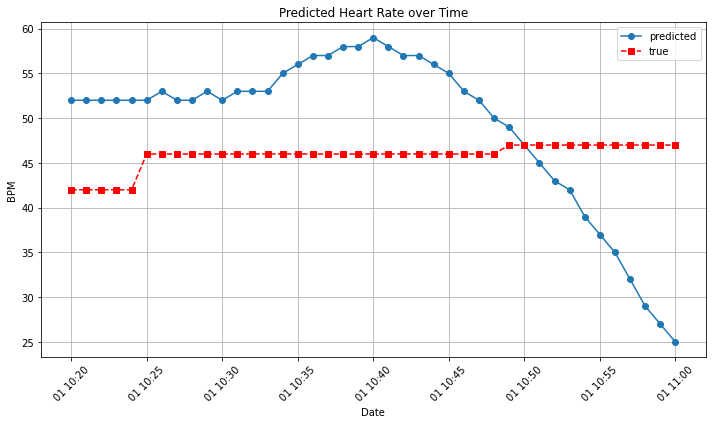

In [35]:
import datetime

import random as r

idx = r.randint(0, X_test.shape[0] - 1)
predictions = model.predict(X_test)[idx].astype(int)
t = ml_data[ (ml_data['start_time'] == int(X_test[idx][0][0])) & (ml_data['end_time'] == int(X_test[idx][1][0]))].iloc[0]


# print(X_test[0], X_test[0][0][0], '\n',ml_data[ml_data['start_time'] == int(X_test[0][0][0])])

start_time = datetime.datetime.strptime('00:00', '%H:%M')
print(start_time + datetime.timedelta(minutes=int(t['start_time'])), start_time + datetime.timedelta(minutes=int(t['end_time'])))
ST = int(t['start_time'])

x = []
y = []
for i in range(t['interval_size']):
    start_date = start_time + datetime.timedelta(minutes=ST + i)
    bpm = predictions[i]
    
    x.append(start_date)
    y.append(bpm)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', label='predicted')
plt.plot(x, t['heart_rate_intervals'][:t['interval_size']], marker='s', linestyle='--', color='r', label='true')
plt.xlabel('Date')
plt.ylabel('BPM')
plt.title('Predicted Heart Rate over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [30]:
# coreml_model = ct.convert(
#     model,
#     inputs = [ct.TensorType(name="lstm_input", shape=(1,4,1))]
# )
# coreml_model.save("LSTMHeartRate.mlmodel")

In [31]:
# model.save('LSTMHeartRateModel')